In [22]:
import os
import mne
import numpy as np
from mne.decoding import SlidingEstimator, cross_val_multiscore
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt



Our goal is to decode object category from the activation patterns captured across our EEG channels. In simpler terms, we're trying to "read" the brain's electrical signals to determine which object is being perceived. Here's a more detailed breakdown:

- **Understanding EEG Signals:** EEG records electrical activity using multiple sensors placed on the scalp. Each sensor (or channel) picks up a mixture of signals from different brain regions. When a participant views an object, specific patterns of activity emerge across these channels.

- **Decoding the Signal:** By analyzing these patterns, we aim to identify unique neural signatures associated with each object category. Essentially, we're training a model to recognize which pattern corresponds to which object, much like learning to differentiate between different accents in spoken language.

**Why It Matters:** Successfully decoding object categories from EEG data can reveal how the brain processes and represents visual information. It provides insights into:

- Neural Representation: How different objects are uniquely encoded in the brain.
- Processing Dynamics: The timing and temporal dynamics of brain activity during object perception.


# Decoding

## Single Subject

We will do all steps of our analysis for a single subject before you should try to extend it to the whole dataset, collecting and plotting results from all participants.

In [27]:
epochs = mne.read_epochs('data/sub-05/eeg/sub-05_repaired-True-epo.fif', verbose="warning")

### Chosing an estimator

Next, let's define the estimator we want to use.

In this step, we choose the algorithm that will learn to distinguish between our classes. Think of this as picking the right recipe to transform raw ingredients into a delicious meal. Each estimator in scikit-learn comes with its own “flavor” and style: some might offer transparent decision-making processes, while others excel at capturing complex patterns even if their inner workings are less interpretable.

For example, a decision tree classifier gives you a clear, visual understanding of the decision rules it creates, much like following a detailed recipe. On the other hand, methods like support vector machines might require more tuning but can be very powerful for certain types of data.

To get a better sense of how different classifiers behave, have a look at [this overview](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html) by scikit-learn. It compares various classifiers, helping you understand the trade-offs in terms of complexity, interpretability, and performance.

In [28]:
est = LinearSVC()

What is the classifier called that we used here? What does the website tell us about this classifier?

Next, let's further prepare our data for decoding by creating **pseudo trials:**

Averaging the epochs for each condition is a common technique in EEG analysis to increase the signal-to-noise ratio. By focusing on the mean response, you obtain a clearer representation of the brain’s activity for each event, which is particularly useful for further analyses like decoding or visualization of neural activation patterns.

In [29]:
conditions = ["Toilette","Toilettenpapier","Waschbecken","Zahnbürste","Herd","Pfanne","Schneidebrett","Brotmesser"]
epochs = mne.concatenate_epochs([epochs[x] for x in conditions])
epochs_pseudo = np.array([epochs[x].get_data(copy=True).mean(axis=0) for x in list(epochs.event_id.keys())])

X = epochs_pseudo # this will be of shape 80, 62, 276 (n_epochs, n_channels, n_times) remember there are 10 exemplars per object category
y = np.repeat(range(len(conditions)), 10) # this is our "target" which corresponds to the object category


Not setting metadata
801 matching events found
Applying baseline correction (mode: mean)


/var/folders/8j/h8w6skpx111fc1wp64yw19kw0000gn/T/ipykernel_28888/3984913109.py:2: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs[x] for x in conditions])


We will now further build up our pipeline. Wonder what `pipeline` refers to? In our analysis, `pipeline` refers to a structured sequence of data processing steps that we apply consistently to our dataset. By chaining these steps together, we ensure that every piece of data is processed in the same way—from scaling to dimensionality reduction—before it is used for further analysis, such as decoding.

Here we will also introduce another important aspect of decoding: **cross-validation.** Cross-validation is a key strategy in decoding to ensure that our model's performance is both reliable and generalizable. It involves partitioning our dataset into multiple subsets, training the model on some subsets, and testing it on others. Cross-validation is essential for validating our decoding approach, making sure our pipeline not only works well on the data we have but is also likely to perform robustly on new, unseen data.

In [30]:
n_splits = 10 
cv = StratifiedKFold(n_splits=n_splits) 
clf = make_pipeline(StandardScaler(), PCA(n_components=.99, svd_solver='full'), est)


To learn more about the specific kind of cross-validation we apply here, check out this [tutorial](https://scikit-learn.org/stable/modules/cross_validation.html). What does it mean for the splits of our data? How many exemplars per category are in each split? 

For our EEG data, which has a time component to it, we will additionally define a so-called [Sliding Estimator](https://mne.tools/stable/generated/mne.decoding.SlidingEstimator.html). 

In [37]:
time_decod = SlidingEstimator(clf, verbose=True)

Now it's time to actually run the decoding for our single subject!

In [38]:
# accuracy scores per validation split
scores = cross_val_multiscore(time_decod, X, y, cv=cv, n_jobs=6, verbose="warning")

Lets have a look what the results can look like for one subject!

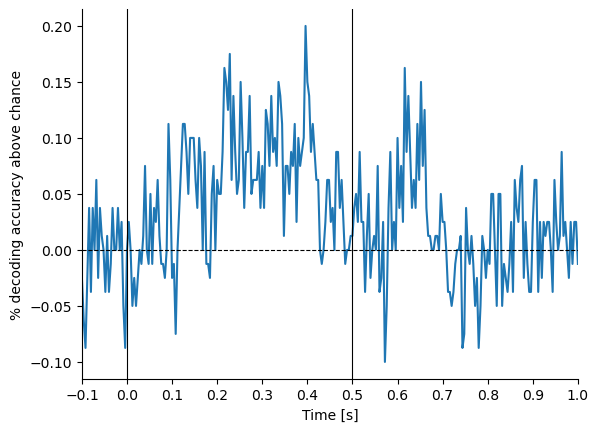

In [39]:
# mean across validation splits
mean_scores = np.mean(scores, axis=0)

# remove chance level
mean_scores -= 1. / len(np.unique(y))

# plot mean accuracy scores across time
fig, ax = plt.subplots()

ax.plot(epochs.times, mean_scores)
ax.axhline(0, color='k', linestyle='--', label='chance', linewidth=.8)
ax.axvline(.0, color='k', linestyle='-', linewidth=.8)
ax.axvline(.5, color='k', linestyle='-', linewidth=.8)
ax.set_ylabel("% decoding accuracy above chance", fontsize=10)
ax.set_xlabel("Time [s]", fontsize=10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks(np.linspace(-0.1, 1, 12))
ax.margins(x=0)


Amazing! Now it's your turn to extend this analysis to all subjects, plotting average scores across participants and giving some indication of variance. 

Feel free to also adjust any parts of the pipeline to see if they make any difference!

## All Subjects (your turn)

In [20]:
# Put your code here

# Cross-Decoding

Expanding on our previous analysis, we now introduce cross decoding—a technique that pushes our investigation further by comparing activation patterns between trials of different objects. Instead of training and testing our classifier within the same object category, cross decoding involves training on one set of objects and testing on another. This allows us to determine whether the neural representations underlying one set of objects generalize to another.

In [40]:
conditions_train = ["Toilette","Waschbecken","Herd","Schneidebrett"] #toilet, sink, stove, cuttingboard
conditions_test = ["Toilettenpapier","Zahnbürste","Pfanne","Brotmesser"] #toiletpaper, toothbrush, pan, breadknife

# as you can see, we're trying to see whether we can generalize between objects of the same phrase!
epochs_train = mne.concatenate_epochs([epochs[x] for x in conditions_train])
epochs_test = mne.concatenate_epochs([epochs[x] for x in conditions_test])

epochs_train_pseudo = np.array([epochs_train[x].get_data(copy=True).mean(axis=0) for x in list(epochs_train.event_id.keys())])
epochs_test_pseudo = np.array([epochs_test[x].get_data(copy=True).mean(axis=0) for x in list(epochs_test.event_id.keys())])

X_train = epochs_train_pseudo
X_test = epochs_test_pseudo
y_train = np.repeat(range(len(conditions_train)), 10)
y_test = np.repeat(range(len(conditions_test)), 10)

time_decod = SlidingEstimator(clf, verbose=True) # we have to re-initialize our time decoder because we have new data
time_decod.fit(X_train, y_train)
scores = time_decod.score(X_test, y_test)
y_pred = time_decod.predict(X_test)


Not setting metadata
400 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
401 matching events found
Applying baseline correction (mode: mean)


  0%|          | Fitting SlidingEstimator : 0/276 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/276 [00:00<?,       ?it/s]

In [ ]:
# remove chance level
scores -= 1. / len(np.unique(y_test))

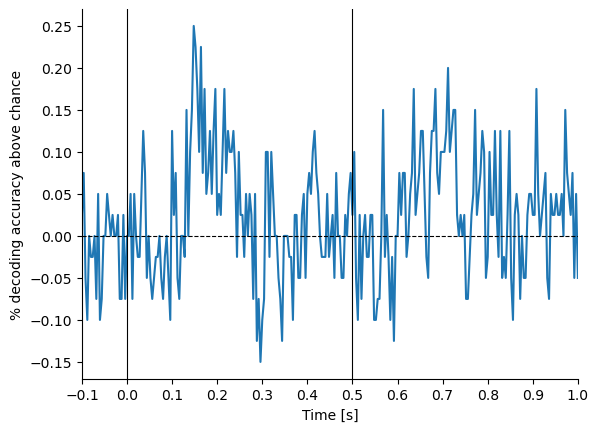

In [42]:
# plot accuracy scores across time
fig, ax = plt.subplots()

ax.plot(epochs.times, scores)
ax.axhline(0, color='k', linestyle='--', label='chance', linewidth=.8)
ax.axvline(.0, color='k', linestyle='-', linewidth=.8)
ax.axvline(.5, color='k', linestyle='-', linewidth=.8)
ax.set_ylabel("% decoding accuracy above chance", fontsize=10)
ax.set_xlabel("Time [s]", fontsize=10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks(np.linspace(-0.1, 1, 12))
ax.margins(x=0)



And again, you should do this for all subjects next!

## All Subjects

In [ ]:
# your code here